# Moving Average Crossover Strategy

1) Simple Moving Average Crossover<br>
2) Exponential Moving Average Crossover<br>

In [2]:
import logging, os, pickle
import requests, glob
from datetime import datetime
import pandas as pd
import time
from datetime import date
import json, re, sys, h5py
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
import shutil
from matplotlib.pyplot import cm
import numpy as np
import scipy.stats as stats
from scipy import stats
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.linear_model import LinearRegression
import sys
import seaborn as sns
sys.path.append('C:\\Users\Bae Kyungmo\OneDrive\Desktop\StockTraidingAutomation\DataModeling')
from Loader_v2 import Loader
ldr = Loader(pwd='')

### 1) Simple MAC process
* Long SMA (100 days)
* Short SMA (20 days)

* If Short SMA > Long SMA buy, else sell.
* A period hyper-parameter can be optimized for a given situation.

In [4]:
def MDD(pr):
    code = pr.columns[0]
    x = pr[code]
    """
    MDD(Maximum Draw-Down)
    :return: (peak_upper, peak_lower, mdd rate)
    """
    arr_v = np.array(x)
    peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
    peak_upper = np.argmax(arr_v[:peak_lower])
    return round((arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper],2)

In [5]:
def SharpeRatio(rt_df, bncmrk=0.02):
    SR = np.sqrt(len(rt_df))*(rt_df['return'].mean() - bncmrk) / rt_df['return'].std()
    return SR

In [6]:
def SMA(pr, ndays=22, min_days=1):
    code = pr.columns[0]
    return pr[[code]].rolling(window=ndays, min_periods=min_days).mean()

In [7]:
def EMA(pr, ndays=22, min_days=1):
    code = pr.columns[0]
    return pr[[code]].ewm(ndays,min_periods=min_days).mean()

In [8]:
def SMA_Label(pr_df, long_d=26, short_d=12, min_days=1):
    pr = pr_df.copy()
    shortSMA = SMA(pr, short_d, min_days=min_days)
    longSMA = SMA(pr, long_d, min_days=min_days)
    pr['SMA_short'] = shortSMA
    pr['SMA_long'] = longSMA
    return pr

In [9]:
def SMA_Signal(dff):
    df = dff.copy()
    df.columns = ['close','SMA_short','SMA_long']
    Buy=[]
    Sell=[]
    Buy.append(np.nan)
    Sell.append(np.nan)
    flag = -1
    for i in range(1, len(df)):
        if df['SMA_short'][i] > df['SMA_long'][i] and flag != 1:
            Buy.append(df['close'][i])
            Sell.append(np.nan)
            flag = 1
        elif df['SMA_short'][i] < df['SMA_long'][i] and flag != 0:
            Sell.append(df['close'][i])
            Buy.append(np.nan)
            flag = 0
        else :
            Buy.append(np.nan)
            Sell.append(np.nan)
    df['BuySignal'] = Buy
    df['SellSignal'] = Sell
    return df

In [10]:
def BackTest(obv):
    tmp = obv[(~obv['BuySignal'].isnull())|(~obv['SellSignal'].isnull())]
    tmp['BuySignal'] = tmp['BuySignal'].fillna(0)
    tmp['SellSignal'] = tmp['SellSignal'].fillna(0)
    tmp['series'] = tmp['BuySignal'] + tmp['SellSignal']
    tmp['return'] = tmp['series'].pct_change()+1
    tmp2 = tmp[tmp.SellSignal!=0.0]
    cm_rt = tmp2['return'].cumprod()[-1]
    hit_ratio = round(len(tmp2[tmp2['return']>=1]) / len(tmp2),2)
    best_rt = tmp2['return'].max()-1
    worst_rt = tmp2['return'].min()-1
    ar_mean = tmp2['return'].mean()
    gr_mean = np.exp(np.log(cm_rt)/len(tmp2))
    mdd = MDD(obv[['close']])
    SR = SharpeRatio(tmp2[['return']]-1)
    test_rst = pd.DataFrame(columns=['CumulativeReturn','HitRatio','BestReturn','WorstReturn','MDD','SimpleMean','GeoMean','#Trade'])
    test_rst.loc[0,'CumulativeReturn'] = round(cm_rt,2)
    test_rst.loc[0,'HitRatio'] = hit_ratio
    test_rst.loc[0,'BestReturn'] = round(best_rt,2)
    test_rst.loc[0,'WorstReturn'] = round(worst_rt,2)
    test_rst.loc[0,'SimpleMean'] = round(ar_mean,2)
    test_rst.loc[0,'GeoMean'] = round(gr_mean,2)
    test_rst.loc[0,'MDD'] = round(mdd*(-1),2)
    test_rst.loc[0,'SharpeRatio'] = round(SR,2)
    test_rst.loc[0,'#Trade'] = round(len(tmp2),2)
    return tmp2, test_rst

In [11]:
def SMA_Run(start, end, code, long_d=26, short_d=12, min_p=1, doplot=True):
    pr = ldr.GetPricelv2(start, end, [code])
    sma = SMA_Label(pr, long_d=long_d, short_d=short_d, min_days=min_p)
    if doplot :
        plt.style.use('fivethirtyeight')
        sma[['SMA_short','SMA_long']].plot(figsize=(8,6))
        plt.title("SMA short & long for {}".format(code))
    sma_sig = SMA_Signal(sma)
    if doplot :
        plt.figure(figsize=(8,6))
        plt.scatter(sma_sig.index, sma_sig['BuySignal'], color='green',label='BuySignal',marker='^',alpha=1)
        plt.scatter(sma_sig.index, sma_sig['SellSignal'], color='red',label='SellSignal',marker='v',alpha=1)
        plt.plot(sma_sig['close'], label='Close Price', alpha=0.35)
        plt.xticks([],rotation=45)
        plt.title('SMA on {} during {} ~ {}'.format(code,start,end))
        plt.xlabel('Date',fontsize=15)
        plt.ylabel('Close Price KRW',fontsize=15)
        plt.legend(loc='upper left')
        plt.show()
    _, rst = BackTest(sma_sig)
    rst.index = [code]
    return rst

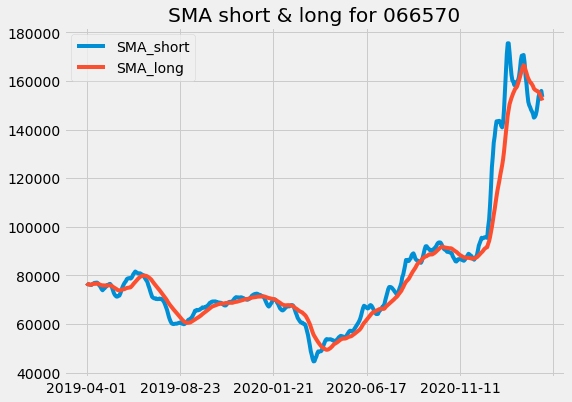

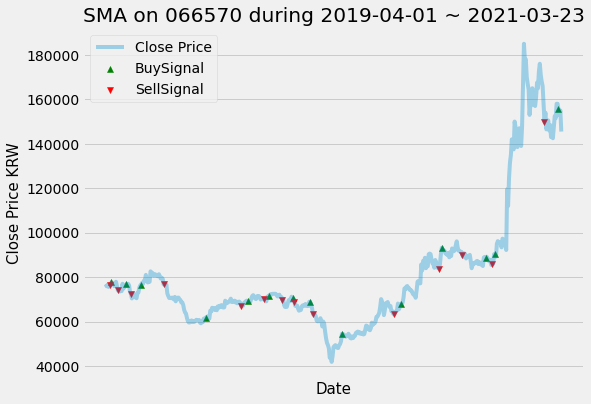

Wall time: 882 ms


,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
066570,1.93,0.43,0.66,-0.08,0.23,1.07,1.05,14,0.86


In [47]:
%%time
SMA_Run('2019-04-01','2021-03-23','066570',22,5,1,True)

In [45]:
%%time
total = pd.DataFrame()
start = '2019-04-01'
end = '2021-03-23'
for cd in ['005930','005935','034220','066570']:
    total = pd.concat([total,SMA_Run(start, end, cd,26,12,1,False)])

Wall time: 707 ms


In [46]:
total

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.28,0.5,0.24,-0.06,0.32,1.03,1.03,10,0.30
005935,1.6,0.56,0.44,-0.05,0.33,1.06,1.05,9,0.84
034220,1.26,0.42,0.43,-0.13,0.6,1.03,1.02,12,0.19
066570,2.61,0.5,0.77,-0.07,0.23,1.17,1.13,8,1.50


### Conclusion
* It seems not better then MACD.
* Hitratio is bad and tuning periods makes volatile results.
* Can be used with other indicators not for a decision making but for complementary check.

---

### 2) 3-EMA process
* Long EMA (50~100 days)
* Middle EMA (20~40 days)
* Short EMA (5~15 days)

* If Short > Middle > Long then buy, else when short < middle sell.
* A period hyper-parameter can be optimized for a given situation.

In [12]:
def EMA_Label(pr_df, long_d=40, mid_d=20, short_d=5, min_days=1):
    pr = pr_df.copy()
    shortEMA = EMA(pr, short_d, min_days=min_days)
    midEMA = EMA(pr, mid_d, min_days=min_days)
    longEMA = EMA(pr, long_d, min_days=min_days)
    pr['EMA_short'] = shortEMA
    pr['EMA_middle'] = midEMA
    pr['EMA_long'] = longEMA
    return pr

In [16]:
def EMA_Signal(dff):
    df = dff.copy()
    df.columns = ['close','EMA_short','EMA_middle','EMA_long']
    Buy=[]
    Sell=[]
    Buy.append(np.nan)
    Sell.append(np.nan)
    flag = -1
    for i in range(1, len(df)):
        if df['EMA_short'][i] > df['EMA_middle'][i] > df['EMA_long'][i] and flag != 1:
            Buy.append(df['close'][i])
            Sell.append(np.nan)
            flag = 1
        elif df['EMA_short'][i] < df['EMA_middle'][i] and flag != 0:
            Sell.append(df['close'][i])
            Buy.append(np.nan)
            flag = 0
        else :
            Buy.append(np.nan)
            Sell.append(np.nan)
    df['BuySignal'] = Buy
    df['SellSignal'] = Sell
    return df

In [17]:
def EMA_Run(start, end, code, long_d=40, mid_d=20, short_d=5, min_p=1, doplot=True):
    pr = ldr.GetPricelv2(start, end, [code])
    ema = EMA_Label(pr, long_d=long_d, mid_d=mid_d, short_d=short_d, min_days=min_p)
    if doplot :
        plt.style.use('fivethirtyeight')
        ema[['EMA_short','EMA_middle','EMA_long']].plot(figsize=(8,6))
        plt.title("EMA short & middle & long for {}".format(code))
    ema_sig = EMA_Signal(ema)
    if doplot :
        plt.figure(figsize=(8,6))
        plt.scatter(ema_sig.index, ema_sig['BuySignal'], color='green',label='BuySignal',marker='^',alpha=1)
        plt.scatter(ema_sig.index, ema_sig['SellSignal'], color='red',label='SellSignal',marker='v',alpha=1)
        plt.plot(ema_sig['close'], label='Close Price', alpha=0.35)
        plt.xticks([],rotation=45)
        plt.title('EMA on {} during {} ~ {}'.format(code,start,end))
        plt.xlabel('Date',fontsize=15)
        plt.ylabel('Close Price KRW',fontsize=15)
        plt.legend(loc='upper left')
        plt.show()
    _, rst = BackTest(ema_sig)
    rst.index = [code]
    return rst

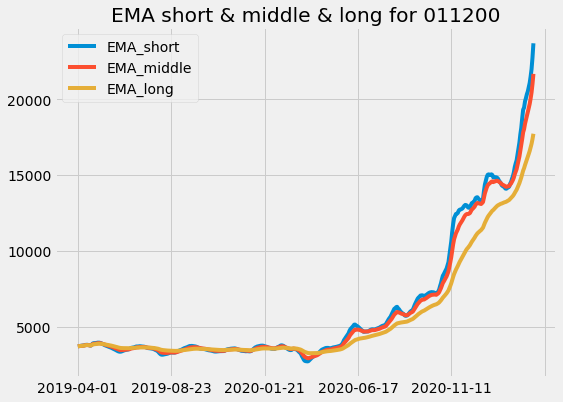

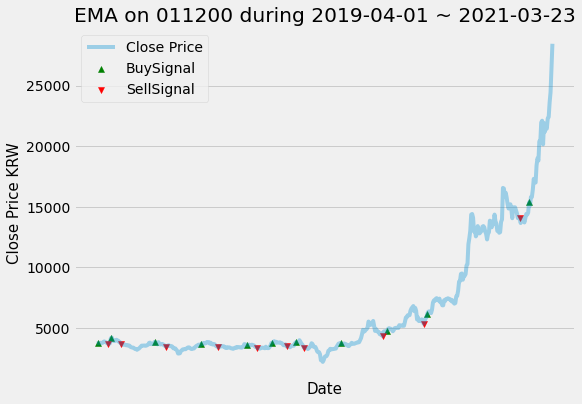

Wall time: 722 ms


,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
011200,1.64,0.3,1.28,-0.12,0.18,1.1,1.05,10,0.59


In [37]:
%%time
EMA_Run('2019-04-01','2021-03-23','011200',30,10,5,1,True)

In [38]:
%%time
total = pd.DataFrame()
start = '2019-04-01'
end = '2021-03-23'
for cd in ['005930','005935','034220','066570']:
    total = pd.concat([total,EMA_Run(start, end, cd,30,10,5,1,False)])

Wall time: 715 ms


In [39]:
total

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.45,0.5,0.36,-0.04,0.32,1.05,1.05,8,0.74
005935,1.62,0.5,0.46,-0.03,0.33,1.07,1.06,8,0.89
034220,1.63,0.6,0.43,-0.09,0.6,1.12,1.1,5,1.04
066570,2.17,0.38,0.62,-0.05,0.23,1.14,1.1,8,1.23


### Conclusion
* It seems not better then MACD likewise SMA does.
* Hitratio is bad and tuning periods makes volatile results.
* Can be used with other indicators not for a decision making but for complementary check.